<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>


# Time series classification

In this notebook, we will build and train deep learning models for time series classification (TSC). 

*Learning objective*

- Learn how to prepare a dataset for time series classification.
- Learn how to use Keras for building a Recurrent Neural Network for TSC.
- Learn how to use Keras for building a 1D CNN for TSC.


# Human activity classification
Smartphones are advanced devices with many different types of sensors. An 'average' smartphone already contains acceleration sensors, gyroscopes, camera('s), microphone(s), and more. By processing the data from these sensors in a smart way, we can determine what a user (carrying the mobile phone) is doing. This so-called 'context information of the user' is very useful to build smart applications.

One recent example of a smart application using the context information of a user is the 'handwashing monitoring' application in Apple's iWatch. This application helps to prevent getting and spreading the Coronavirus. When a user arrives at home the iWatch gives a signal to wash the hands. The iWatch is able to detect when a user starts washing his/her hands and when the user is ready. This is done using the motion sensors of the iWatch. When a user washes his/her hands for more than 20 seconds a reward is given.

Next to motion sensing, mobile phones and smartwatches will get more and more sensors to measure bio-signals, such as heart rate, blood pressure, skin conductivity, and temperature. All in all, more time-series data is generated by these devices, and time-series models are needed to do something useful with the data.

In this notebook, we will build times series classification models to detect the activity of a user using motion data from a mobile phone. We will use the 'human activity' dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). 


## Dataset
The following description is taken from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) website.

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers were selected for generating the training data and 30% for the test data. 

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low-frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

Check the README.txt file for further details about this dataset. 

A video of the experiment including an example of the 6 recorded activities with one of the participants can be seen below.

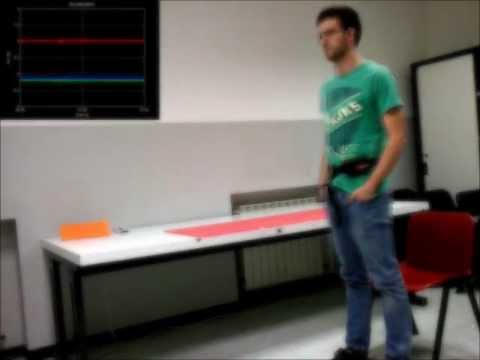

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('XOEN9W05_4A', width=800, height=600)

An updated version of this dataset can be found at [here](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions). It includes labels of postural transitions between activities and also the full raw inertial signals instead of the ones pre-processed into windows.

Attribute Information:

For each record in the dataset it is provided: 
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 
- An identifier of the subject who carried out the experiment.

# Preparing data
We start with importing the dataset and transforming it into well defined numpy arrays.

In [6]:
# import some standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from os.path import join

tf.__version__

'2.1.0'

## Importing the data

Importing and preparing data always require some effort. Our dataset is stored in txt files. It is insightful to open one of these txt files yourself and check how to data is stored. We will use the `read_fwf` function from pandas to read the data. This function reads a table of fixed-width formatted lines into DataFrame.

In [26]:
def download_file(url, path):
    """
    Download file and save it to the defined location
    
    https://stackoverflow.com/questions/37573483/progress-bar-while-download-file-over-http-with-requests/37573701
    """
    import requests
    from tqdm.notebook import tqdm
    import os
    
    
    if os.path.exists(path):
        print('File "{}" already exists. Skipping download.'.format(path))
        return
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")
        
def unzip(path_to_zip, folder_name):
    import zipfile
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall(folder_name)
    print('Extracted {} content to {}'.format(path_to_zip, folder_name))
    

PATH_TO_ZIP = join('data', 'HAPT.zip')
URL = 'https://github.com/illyakaynov/masterclass_datasets/raw/master/UCI%20HAR%20Dataset.zip'
DATA_FOLDER = join('data', 'HAPT')


download_file(URL, PATH_TO_ZIP)
unzip(PATH_TO_ZIP, DATA_FOLDER)

  0%|          | 0.00/61.0M [00:00<?, ?iB/s]

Extracted data\HAPT.zip content to data\HAPT


In [30]:
# root to dataset
PATH = join('data', 'HAPT', 'UCI HAR Dataset')

# list of feature names
features = ['body_acc_x', 'body_acc_y', 'body_acc_z', \
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z', \
            'total_acc_x', 'total_acc_y', 'total_acc_z']

# import train data
data_train = {}
for fn in features:
    filename = join(PATH, 'train', 'Inertial Signals', fn + '_train.txt')
    data_train[fn] = pd.read_fwf(filename, header=None)

# labels are from 1 to 6, we use 0 to 5    
data_train['y'] = pd.read_fwf(join(PATH, 'train', 'y_train.txt'), header=None)  - 1  

# import test data
data_test = {}
for fn in features:
    filename = join(PATH, 'test', 'Inertial Signals', fn + '_test.txt')
    data_test[fn] = pd.read_fwf(filename, header=None)
    
# labels are from 1 to 6, we use 0 to 5    
data_test['y'] = pd.read_fwf(join(PATH, 'test', 'y_test.txt'), header=None) - 1  

# define activity labels
labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

In [31]:
# check shape of data
data_train['body_acc_x'].shape, data_test['body_acc_x'].shape

((7352, 128), (2947, 128))

Next, we define a function to plot data.

In [32]:
def plot_timeseries(data, idx, ylim=None):
    """Plot time serie data."""
    fig, axs = plt.subplots(3, 1, figsize=(14, 7))
    fig.subplots_adjust(top=0.95)

    for j in range(9):
        i = j // 3
        axs[i].plot(data_train[features[j]].values[idx,:], label=features[j])
        if ylim:
            axs[i].set_ylim(ylim)
        axs[i].legend()
    plt.suptitle(labels[data_train['y'].values[idx][0]])

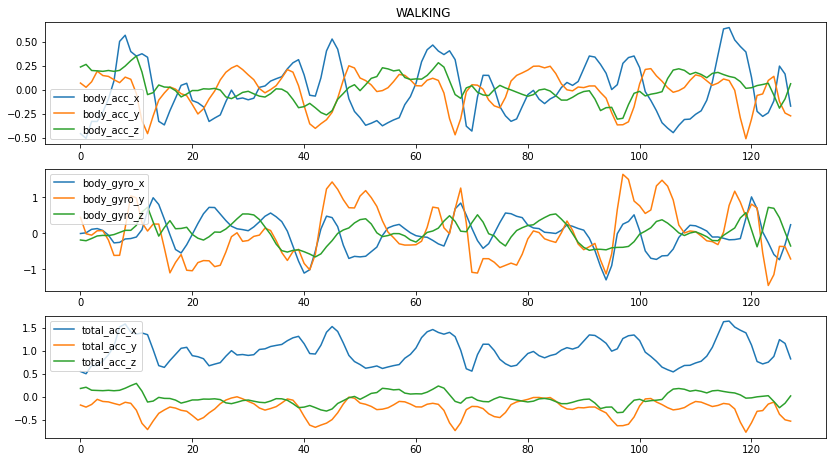

In [33]:
plot_timeseries(data_train, idx=100)

We will normalize the data before using it for training.

In [34]:
# normalize data between -1 and 1
# normale data per feature set (body_acc_, body_gyro_, total_acc_)
f_min, f_max = {}, {}
for f in features:
    f_min[f] = min(data_train[f].min().min(), data_test[f].min().min())
    f_max[f] = max(data_train[f].max().max(), data_test[f].max().max())

for f in features:
    data_train[f] = -1. + 2. * (data_train[f] - f_min[f]) / (f_max[f] - f_min[f])
    data_test[f] = -1. + 2. * (data_test[f] - f_min[f]) / (f_max[f] - f_min[f])

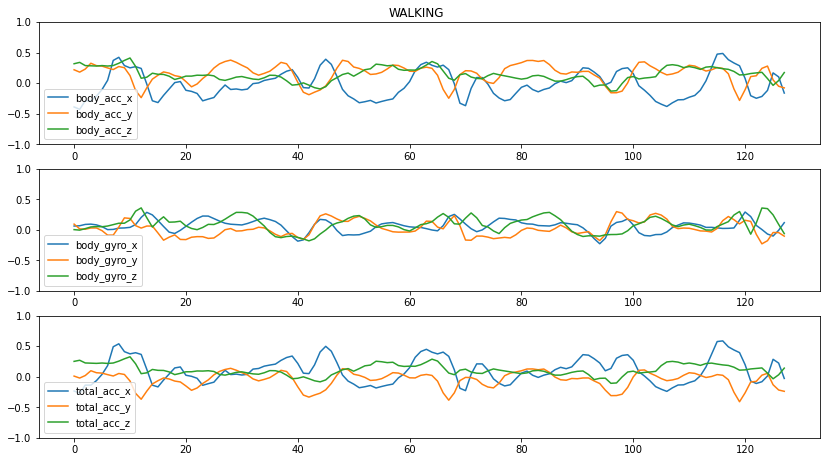

In [35]:
plot_timeseries(data_train, idx=100, ylim=(-1,1))

By selecting a different index (idx) another time series sample can be plotted.

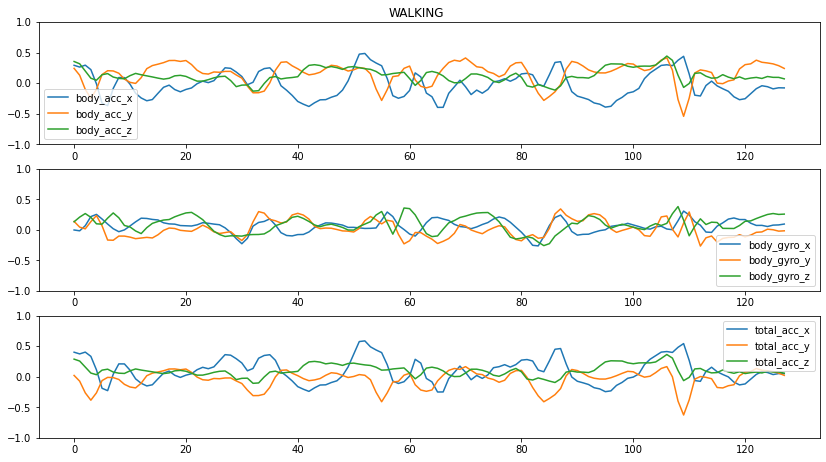

In [37]:
plot_timeseries(data_train, idx=101, ylim=(-1,1))

Finally, we convert the data to numpy arrays for training purpose.

In [38]:
n_batches_train = data_train['body_acc_x'].shape[0]
n_batches_val   = data_test['body_acc_x'].shape[0]
n_timesteps     = data_train['body_acc_x'].shape[1]
n_inputs = 9
n_outputs = 1

# create train set
X_train = np.empty((n_batches_train, n_timesteps, n_inputs))
y_train = np.empty(n_batches_train)

for i, f in enumerate(features):
    X_train[:,:,i] = data_train[f].values
y_train = data_train['y'].values[:,0]

# validation set
# the test set is used as validation set
X_val = np.empty((n_batches_val, n_timesteps, n_inputs))
y_val = np.empty(n_batches_val)

for i, f in enumerate(features):
    X_val[:,:,i] = data_test[f].values
y_val = data_test['y'].values[:,0]

In [39]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((7352, 128, 9), (7352,), (2947, 128, 9), (2947,))

By plotting the labels of the timeseries we observe that the dataset is not shuffled. This might influence the training result. Therefore, after converting the labels to one-hot-encoded labels we will shuffle all learning samples.

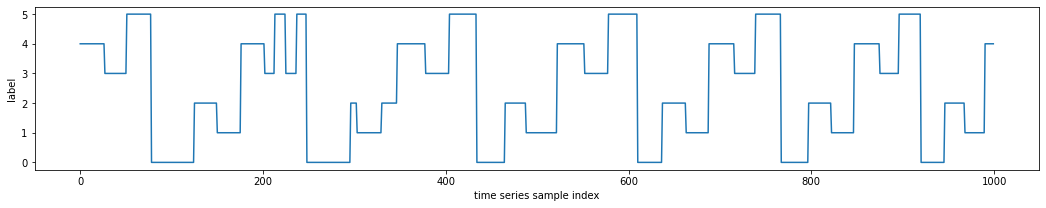

In [40]:
plt.figure(figsize=(18,3))
plt.plot(y_train[:1000])
plt.xlabel('time series sample index')
plt.ylabel('label');

In [41]:
# reformat target vector from categorical label to one-hot-encoding
from tensorflow.keras import utils

# reformat labels to one-hot-encoded labels
print('Before y_train[0] = {}'.format(y_train[0]))
y_train = utils.to_categorical(y_train, 10)
y_val = utils.to_categorical(y_val, 10)
print('After y_train[0] = {}'.format(y_train[0]))

Before y_train[0] = 4
After y_train[0] = [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [42]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [43]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((7352, 128, 9), (7352, 10), (2947, 128, 9), (2947, 10))

# Training RNN model

When the dataset is prepared for training models, we can start building a model. The first model we will train is a RNN using LSTM cells. We will create an RNN with two layers of LSTM cells.

In [44]:
hidden_state_dim = 100
n_outputs_1he = 10

model  = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(hidden_state_dim, input_shape=[None, n_inputs], return_sequences=True),
    tf.keras.layers.LSTM(hidden_state_dim, input_shape=[None, n_inputs]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(n_outputs_1he, activation='softmax')
])

# define model optimization method
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         44000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 135,510
Trainable params: 135,510
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=2)

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 - 30s - loss: 1.0722 - categorical_accuracy: 0.5256 - val_loss: 1.1756 - val_categorical_accuracy: 0.4462
Epoch 2/50
7352/7352 - 29s - loss: 0.9997 - categorical_accuracy: 0.5658 - val_loss: 1.1773 - val_categorical_accuracy: 0.4883
Epoch 3/50
7352/7352 - 50s - loss: 0.9671 - categorical_accuracy: 0.5789 - val_loss: 1.1747 - val_categorical_accuracy: 0.5083
Epoch 4/50
7352/7352 - 58s - loss: 0.8788 - categorical_accuracy: 0.6307 - val_loss: 0.9887 - val_categorical_accuracy: 0.6108
Epoch 5/50
7352/7352 - 38s - loss: 0.6801 - categorical_accuracy: 0.7078 - val_loss: 0.6673 - val_categorical_accuracy: 0.6990
Epoch 6/50
7352/7352 - 39s - loss: 0.5331 - categorical_accuracy: 0.7612 - val_loss: 0.5955 - val_categorical_accuracy: 0.7133
Epoch 7/50
7352/7352 - 37s - loss: 0.4936 - categorical_accuracy: 0.7749 - val_loss: 0.5584 - val_categorical_accuracy: 0.7448
Epoch 8/50
7352/7352 - 36s - loss: 0.5638 - categorical_accurac

To visualize the learning results, we define a function to plot the learning history as well as the confusion matrix.

In [48]:
def plot_history(history):
    # plot training loss history
    fig, axs = plt.subplots(1, 2, figsize=(16,6))

    loss_values  = history.history['loss']
    val_loss_values  = history.history['val_loss']

    epochs = range(1, len(loss_values)+1)

    axs[0].plot(epochs, loss_values, 'bo', label='Training loss')
    axs[0].plot(epochs, val_loss_values, 'b', label='Validation loss')
    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()


    loss_values  = history.history['categorical_accuracy']
    val_loss_values  = history.history['val_categorical_accuracy']

    axs[1].plot(epochs, loss_values, 'bo', label='Training accuracy')
    axs[1].plot(epochs, val_loss_values, 'b', label='Validation accuracy')
    axs[1].set_title('Training and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend();

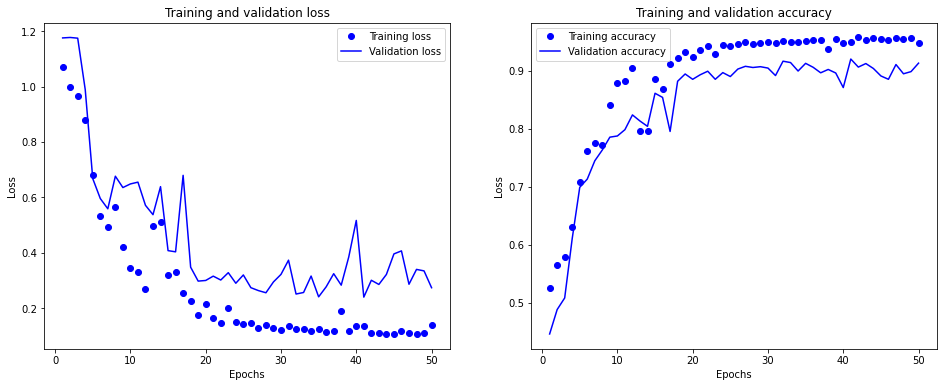

In [49]:
plot_history(history)

In [50]:
# Evaluate performance of model by plotting confusion matrix
from sklearn.metrics import confusion_matrix

# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def accuracy(y, y_pred):
    return np.sum(y==y_pred)/len(y)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm = cm[::-1,:]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xlim((-0.5, len(classes) - 0.5))
    plt.ylim((-0.5, len(classes) - 0.5))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes[::-1])
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

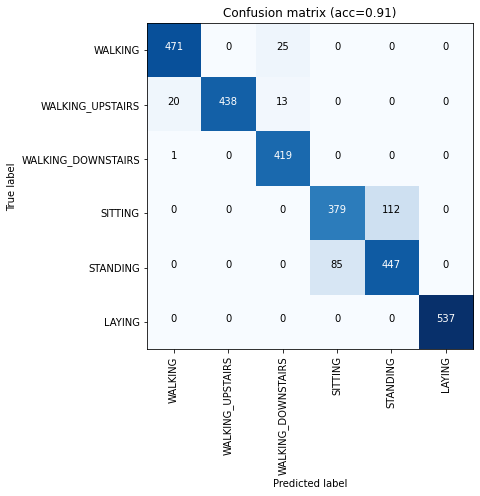

In [51]:
# predict labels from validation set
y_pred = model.predict(X_val)

# convert data to label number
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_val, axis=1) 

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred) 

# plot the confusion matrix
plot_confusion_matrix(cm, 
                      title='Confusion matrix (acc={:0.2f})'.format(accuracy(y_true, y_pred)), 
                      classes = labels)

The accuracy of this model will be around 91%, which is not bad for a first model.

# 1D Conv

In stead of using RNNs we can also use 1D convolutional networks. The paper ["Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline"](https://arxiv.org/pdf/1611.06455.pdf) gives an overview of techniques for time series classification. Here we adopt the baseline model from the paper that give the best performance.

In [52]:
n_outputs_1he = 10
n_length = 128
n_features = 9

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, input_shape=(n_length,n_features)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(n_outputs_1he, activation='softmax'))

# define model optimization method
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 126, 64)           1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 64)           256       
_________________________________________________________________
re_lu (ReLU)                 (None, 126, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 124, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 124, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 122, 64)          

In [54]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=2)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 - 4s - loss: 0.6867 - categorical_accuracy: 0.8498 - val_loss: 2.2700 - val_categorical_accuracy: 0.2745
Epoch 2/20
7352/7352 - 3s - loss: 0.2387 - categorical_accuracy: 0.9431 - val_loss: 2.4388 - val_categorical_accuracy: 0.2786
Epoch 3/20
7352/7352 - 3s - loss: 0.1704 - categorical_accuracy: 0.9472 - val_loss: 1.5945 - val_categorical_accuracy: 0.4913
Epoch 4/20
7352/7352 - 3s - loss: 0.1441 - categorical_accuracy: 0.9508 - val_loss: 0.5798 - val_categorical_accuracy: 0.7811
Epoch 5/20
7352/7352 - 3s - loss: 0.1304 - categorical_accuracy: 0.9543 - val_loss: 0.2737 - val_categorical_accuracy: 0.9237
Epoch 6/20
7352/7352 - 3s - loss: 0.1254 - categorical_accuracy: 0.9533 - val_loss: 0.2245 - val_categorical_accuracy: 0.9294
Epoch 7/20
7352/7352 - 4s - loss: 0.1208 - categorical_accuracy: 0.9520 - val_loss: 0.2231 - val_categorical_accuracy: 0.9260
Epoch 8/20
7352/7352 - 4s - loss: 0.1120 - categorical_accuracy: 0.951

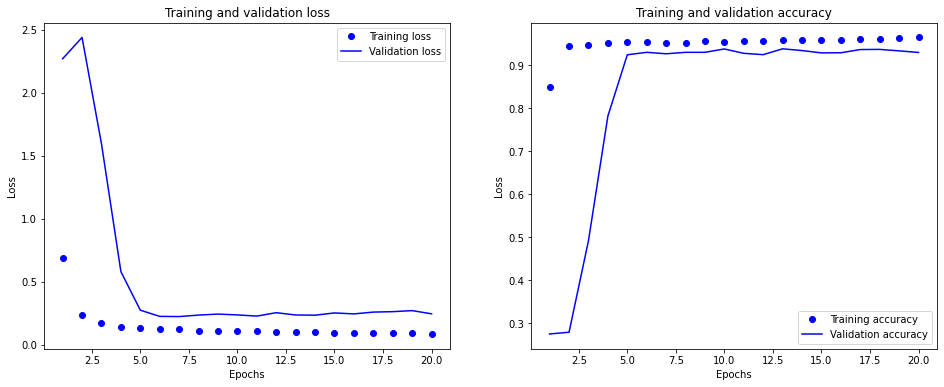

In [55]:
plot_history(history)

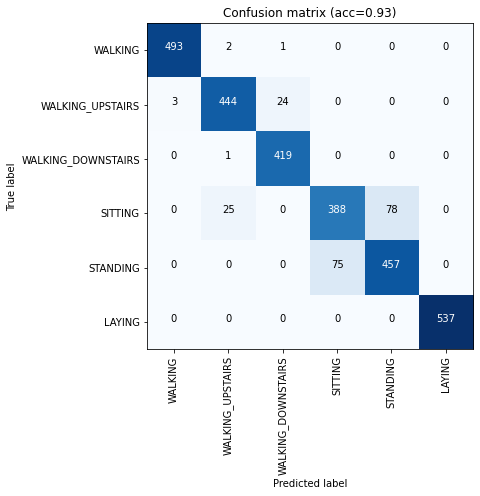

In [56]:
# predict labels from validation set
y_pred = model.predict(X_val)

# convert data to label number
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_val, axis=1) 

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred) 

# plot the confusion matrix
plot_confusion_matrix(cm, 
                      title='Confusion matrix (acc={:0.2f})'.format(accuracy(y_true, y_pred)), 
                      classes = labels)

As can be seen from the learning history, this model quickly converges to an optimal solution. The accuracy will be around 93%, which is better than the RNN.

We can make a variation on this model by using e.g. dilated convolutions to increase the receptive field of the convolutions.

In [67]:
n_outputs_1he = 10
n_length = 128
n_features = 9

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, input_shape=(n_length,n_features)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, dilation_rate=2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, dilation_rate=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(100, activation='tanh'))
model.add(tf.keras.layers.Dense(n_outputs_1he, activation='softmax'))

# define model optimization method
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [68]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 124, 64)           2944      
_________________________________________________________________
batch_normalization_15 (Batc (None, 124, 64)           256       
_________________________________________________________________
dropout_16 (Dropout)         (None, 124, 64)           0         
_________________________________________________________________
re_lu_15 (ReLU)              (None, 124, 64)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 116, 64)           20544     
_________________________________________________________________
batch_normalization_16 (Batc (None, 116, 64)           256       
_________________________________________________________________
dropout_17 (Dropout)         (None, 116, 64)          

In [69]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=2)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 - 7s - loss: 1.7269 - categorical_accuracy: 0.4325 - val_loss: 2.0366 - val_categorical_accuracy: 0.2033
Epoch 2/20
7352/7352 - 6s - loss: 1.0031 - categorical_accuracy: 0.6587 - val_loss: 2.2878 - val_categorical_accuracy: 0.1988
Epoch 3/20
7352/7352 - 6s - loss: 0.7580 - categorical_accuracy: 0.7376 - val_loss: 2.0047 - val_categorical_accuracy: 0.4123
Epoch 4/20
7352/7352 - 6s - loss: 0.6269 - categorical_accuracy: 0.7934 - val_loss: 1.2534 - val_categorical_accuracy: 0.5222
Epoch 5/20
7352/7352 - 6s - loss: 0.5254 - categorical_accuracy: 0.8252 - val_loss: 0.6441 - val_categorical_accuracy: 0.7218
Epoch 6/20
7352/7352 - 6s - loss: 0.4437 - categorical_accuracy: 0.8562 - val_loss: 0.4651 - val_categorical_accuracy: 0.8347
Epoch 7/20
7352/7352 - 7s - loss: 0.3704 - categorical_accuracy: 0.8834 - val_loss: 0.3802 - val_categorical_accuracy: 0.8649
Epoch 8/20
7352/7352 - 6s - loss: 0.3265 - categorical_accuracy: 0.895

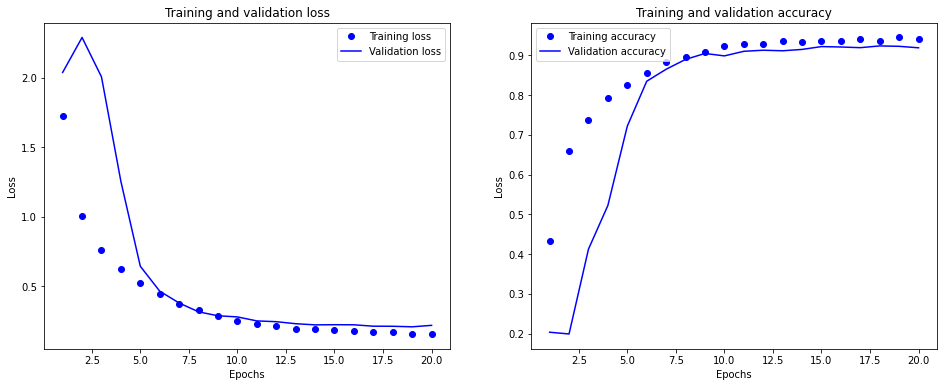

In [70]:
plot_history(history)

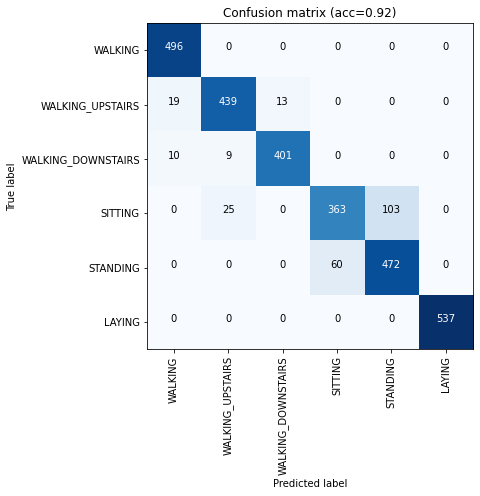

In [71]:
# predict labels from validation set
y_pred = model.predict(X_val)

# convert data to label number
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_val, axis=1) 

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred) 

# plot the confusion matrix
plot_confusion_matrix(cm, 
                      title='Confusion matrix (acc={:0.2f})'.format(accuracy(y_true, y_pred)), 
                      classes = labels)

In this case the dilated convolution did not improve the performance any further. When comparing the three confusion matrices, we notice that 'SITTING' is often confused with 'WALKING_UPSTAIRS'. As this intuitively seems strange (we expect walking to generate more dynamic signals than sitting) it would be a good starting point to investigate the data further for clues how to improve the model performance.

## Exercise

Create your own model and try to improve the accuracy of the model.